# 2D Periodic Poisson Solver

**Problem:** Solve the 2D Poisson equation $-\Delta u = f$ with periodic boundary conditions on $[0, 2\pi)^2$, where samples are given on a non-Cartesian (warped) grid.

This example follows the [FINUFFT tutorial](https://finufft.readthedocs.io/en/latest/tutorial/peripois2d_python.html). It demonstrates how NUFFT enables spectral methods on arbitrary point distributions.

## Setup

First, install nufftax if running on Colab:

In [ ]:
# Uncomment the following lines to install nufftax on Colab
# !pip install uv
# !uv pip install nufftax --system

In [2]:
import jax
jax.config.update("jax_enable_x64", True)  # Required for high precision

import numpy as np
import jax.numpy as jnp
from nufftax import nufft2d1, nufft2d2
import matplotlib.pyplot as plt
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Mathematical Background

The spectral method for Poisson's equation has three steps:

1. Compute Fourier coefficients: $\hat{f}(k) = \int f(x) e^{i k \cdot x} dx$
2. Divide by $|k|^2$: $\hat{u}(k) = \hat{f}(k) / |k|^2$
3. Evaluate solution: $u(x) = \sum_k \hat{u}(k) e^{-i k \cdot x}$

On uniform grids, steps 1 and 3 use FFT. On non-Cartesian grids, we replace them with NUFFT.

## Define the Problem

We use a source function with two Gaussian bumps and a smooth coordinate transformation.

In [3]:
# Source: two Gaussian bumps
w0 = 0.1
src = lambda x, y: (np.exp(-0.5*((x-1)**2+(y-2)**2)/w0**2)
                  - np.exp(-0.5*((x-3)**2+(y-5)**2)/w0**2))

# Smooth coordinate transformation: (t,s) -> (x,y)
deform = lambda t, s: np.stack([
    t + 0.5*np.sin(t) + 0.2*np.sin(2*s),
    s + 0.3*np.sin(2*s) + 0.3*np.sin(s-t)
])

# Jacobian matrix for quadrature weights
deformJ = lambda t, s: np.stack([
    np.stack([1 + 0.5*np.cos(t), 0.4*np.cos(2*s)], axis=-1),
    np.stack([-0.3*np.cos(s-t), 1 + 0.6*np.cos(2*s) + 0.3*np.cos(s-t)], axis=-1)
], axis=-1)

## FFT Solver (Reference)

First, let's implement the FFT-based solver on a uniform grid as reference.

In [4]:
def solve_fft(n):
    """FFT-based Poisson solver on uniform grid."""
    x = 2*np.pi*np.arange(n) / n
    xx, yy = np.meshgrid(x, x)
    f = src(xx, yy)
    
    # Forward FFT
    fhat = np.fft.ifft2(f)
    
    # Frequency grid
    k = np.fft.fftfreq(n) * n
    kx, ky = np.meshgrid(k, k)
    
    # Inverse Laplacian filter (zero at k=0 and Nyquist)
    kfilter = 1. / (kx**2 + ky**2)
    kfilter[0, 0] = 0
    kfilter[n//2, :] = 0
    kfilter[:, n//2] = 0
    
    # Inverse FFT
    u = np.fft.fft2(kfilter * fhat).real
    return u, xx, yy, f

In [5]:
print("FFT-based solver on uniform grid:")
print("-" * 40)
for n in [40, 60, 80, 100, 120]:
    u, _, _, _ = solve_fft(n)
    print(f"n={n}:  u(0,0) = {u[0,0]:.15e}")

FFT-based solver on uniform grid:
----------------------------------------
n=40:  u(0,0) = 1.551906153625020e-03
n=60:  u(0,0) = 1.549852227637310e-03
n=80:  u(0,0) = 1.549852190998225e-03
n=100:  u(0,0) = 1.549852191075838e-03
n=120:  u(0,0) = 1.549852191075829e-03


## NUFFT Solver

Now let's implement the NUFFT-based solver that works on warped grids.

In [6]:
def solve_nufft(n, tol=1e-12):
    """Solve -Δu = f on warped grid using NUFFT."""
    # Parameter grid
    t = 2 * np.pi * np.arange(n) / n
    tt, ss = np.meshgrid(t, t)
    
    # Physical coordinates (warped)
    xxx = deform(tt, ss)
    xx, yy = xxx[0], xxx[1]
    
    # Jacobian determinant for quadrature weights
    J = deformJ(tt.T, ss.T)
    detJ = np.linalg.det(J).T
    ww = detJ / n**2  # Quadrature weight = |det(J)| * (2π/n)²
    
    f = src(xx, yy)
    Nk = int(2 * np.ceil(0.5 * n / 2))  # Number of modes
    
    # Type-1 NUFFT: compute Fourier coefficients
    fhat = np.array(nufft2d1(
        jnp.array(xx.ravel()), jnp.array(yy.ravel()),
        jnp.array((f * ww).ravel().astype(np.complex128)),
        n_modes=(Nk, Nk), isign=1, eps=tol
    ))
    
    # Convert centered output to FFT ordering
    fhat_fft = np.fft.ifftshift(fhat)
    
    # Inverse Laplacian filter (zero at k=0 and Nyquist)
    k = np.fft.fftfreq(Nk) * Nk
    kx, ky = np.meshgrid(k, k)
    kfilter = 1. / (kx**2 + ky**2)
    kfilter[0, 0] = 0
    kfilter[Nk//2, :] = 0
    kfilter[:, Nk//2] = 0
    
    # Convert back to centered ordering for Type-2
    uhat = np.fft.fftshift(kfilter * fhat_fft)
    
    # Type-2 NUFFT: evaluate solution at warped points
    u = np.array(nufft2d2(
        jnp.array(xx.ravel()), jnp.array(yy.ravel()),
        jnp.array(uhat), isign=-1, eps=tol
    )).real.reshape((n, n))
    
    return u, xx, yy, f

In [7]:
print("NUFFT-based solver on warped grid:")
print("-" * 40)
for n in [80, 120, 160, 200, 240]:
    u, _, _, _ = solve_nufft(n)
    Nk = int(2 * np.ceil(0.5 * n / 2))
    print(f"n={n}: Nk={Nk}  u(0,0) = {u[0,0]:.15e}")

NUFFT-based solver on warped grid:
----------------------------------------


n=80: Nk=40  u(0,0) = 1.549915296572036e-03


n=120: Nk=60  u(0,0) = 1.549851996887887e-03


n=160: Nk=80  u(0,0) = 1.549852191030718e-03


n=200: Nk=100  u(0,0) = 1.549851274681522e-03


n=240: Nk=120  u(0,0) = 1.549852191075837e-03


## Visualization

Let's visualize the source function, solution, and convergence.

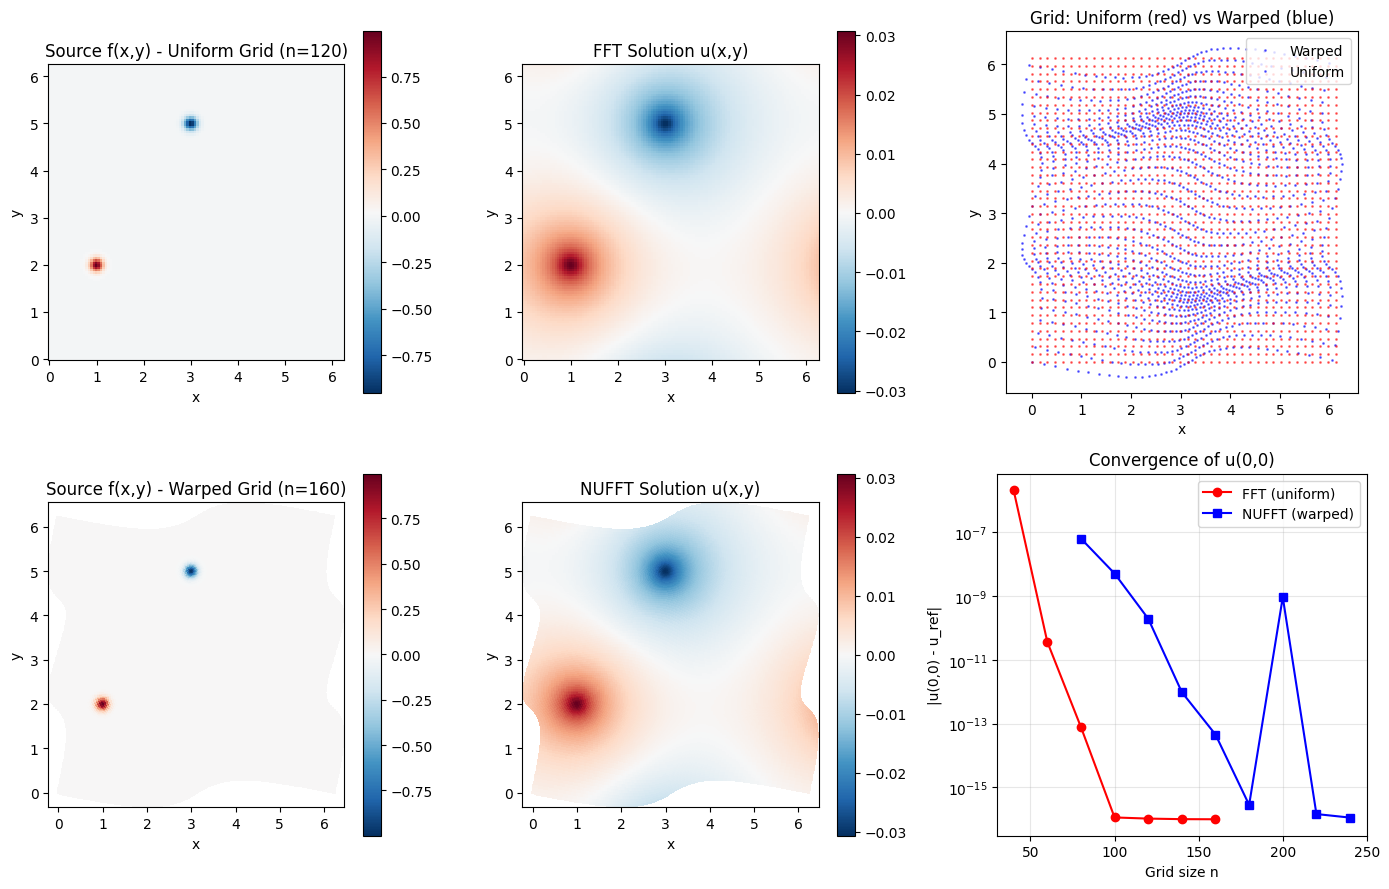

In [8]:
# Plotting code (click to expand)
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

# FFT solution on uniform grid
n_fft = 120
u_fft, xx_fft, yy_fft, f_fft = solve_fft(n_fft)

ax = axes[0, 0]
im = ax.pcolormesh(xx_fft, yy_fft, f_fft, cmap='RdBu_r', shading='auto')
ax.set_title(f'Source f(x,y) - Uniform Grid (n={n_fft})')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax)

ax = axes[0, 1]
im = ax.pcolormesh(xx_fft, yy_fft, u_fft, cmap='RdBu_r', shading='auto')
ax.set_title(f'FFT Solution u(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax)

# NUFFT solution on warped grid
n_nufft = 160
u_nufft, xx_nufft, yy_nufft, f_nufft = solve_nufft(n_nufft)

ax = axes[1, 0]
im = ax.pcolormesh(xx_nufft, yy_nufft, f_nufft, cmap='RdBu_r', shading='auto')
ax.set_title(f'Source f(x,y) - Warped Grid (n={n_nufft})')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax)

ax = axes[1, 1]
im = ax.pcolormesh(xx_nufft, yy_nufft, u_nufft, cmap='RdBu_r', shading='auto')
ax.set_title(f'NUFFT Solution u(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.colorbar(im, ax=ax)

# Grid visualization
ax = axes[0, 2]
n_grid = 40
t = 2 * np.pi * np.arange(n_grid) / n_grid
tt, ss = np.meshgrid(t, t)
xxx = deform(tt, ss)
ax.plot(xxx[0], xxx[1], 'b.', markersize=2, alpha=0.5)
ax.plot(tt, ss, 'r.', markersize=2, alpha=0.5)
ax.set_title('Grid: Uniform (red) vs Warped (blue)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.legend(['Warped', 'Uniform'], loc='upper right')

# Convergence plot
ax = axes[1, 2]

# FFT convergence
ns_fft = [40, 60, 80, 100, 120, 140, 160]
u00_fft = []
for n in ns_fft:
    u, _, _, _ = solve_fft(n)
    u00_fft.append(u[0, 0])

# NUFFT convergence  
ns_nufft = [80, 100, 120, 140, 160, 180, 200, 220, 240]
u00_nufft = []
for n in ns_nufft:
    u, _, _, _ = solve_nufft(n)
    u00_nufft.append(u[0, 0])

# Reference value (converged)
u_ref = u00_fft[-1]

ax.semilogy(ns_fft, np.abs(np.array(u00_fft) - u_ref) + 1e-16, 'ro-', label='FFT (uniform)')
ax.semilogy(ns_nufft, np.abs(np.array(u00_nufft) - u_ref) + 1e-16, 'bs-', label='NUFFT (warped)')
ax.set_xlabel('Grid size n')
ax.set_ylabel('|u(0,0) - u_ref|')
ax.set_title('Convergence of u(0,0)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Fourier Mode Decay

The decay of the Fourier modes $\hat{f}$ on a log plot for both FFT and NUFFT versions:

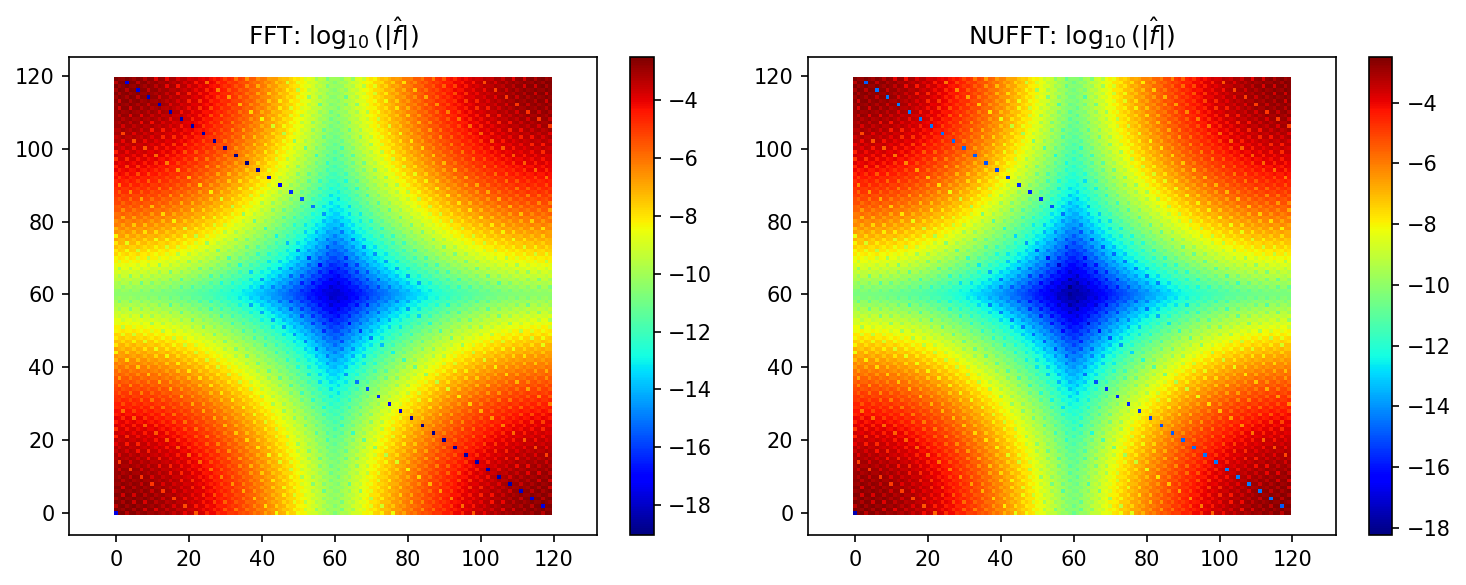

In [9]:
# Compute Fourier coefficients for comparison (click to expand)
n = 120
tol = 1e-12

# FFT version on uniform grid
x = 2*np.pi*np.arange(n) / n
xx, yy = np.meshgrid(x, x)
f = src(xx, yy)
fhat_fft = np.fft.ifft2(f)

# NUFFT version on uniform grid (to compare apples to apples)
fhat_nufft = np.array(nufft2d1(
    jnp.array(xx.ravel()), jnp.array(yy.ravel()),
    jnp.array((f / n**2).ravel().astype(np.complex128)),
    n_modes=(n, n), isign=1, eps=tol, modeord=1
))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
cax = ax[0].imshow(np.log10(np.abs(fhat_fft) + 1e-20), origin="lower", cmap="jet")
fig.colorbar(cax, ax=ax[0])
ax[0].set_title(r"FFT: $\log_{10}(|\hat{f}|)$")
ax[0].axis("equal")

cax = ax[1].imshow(np.log10(np.abs(fhat_nufft) + 1e-20), origin="lower", cmap="jet")
fig.colorbar(cax, ax=ax[1])
ax[1].set_title(r"NUFFT: $\log_{10}(|\hat{f}|)$")
ax[1].axis("equal")

fig.tight_layout()
plt.show()